# Wine Price Prediction - Model Training v4

- **v1** - Trained simple DL model and LGB model
- **v2** - Tried wider and deeper DL models
- **v3** - Dataset updated with a new feature
- **v4** - Trained the final model

## Data and Use case

[**Wine Reviews** - 130k wine reviews with variety, location, winery, price, and description](https://www.kaggle.com/zynicide/wine-reviews/home)

This dataset is available on Kaggle and contains around 130k of wine reviews. The data was scraped from [WineEnthusiast](http://www.winemag.com/?s=&drink_type=wine) on November 22nd, 2017.

I plan to use this dataset to develop a model that predicts wine price for specified set of parameters, like wine variety, region, desired quality. Such model, may be integrated into an application that runs on a mobile device to suggest price range during wine shopping without need to do online search.

## Model Training
In this task, the model is trained. This task is set apart from model definition and evaluation for various reasons. For instance, training is a computationally intense task which might be scaled on computer clusters or GPUs

In [2]:
seed=123

import numpy.random as nr
nr.seed(seed)
from tensorflow import set_random_seed
set_random_seed(seed)

## Split into Training and Test Data

Let's load the features we modeled from COS.

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
from io import StringIO
import requests
import json
import pandas as pd

df_data_1 = pd.read_csv('wine-data-features.v2.zip')
df_data_1.head()

,price,country_code,province_code,variety_code,points_code,age_code
0,15.0,30,106,435,2,1
1,14.0,39,261,421,2,0
2,13.0,39,212,463,2,0
3,65.0,39,261,425,2,0
4,15.0,36,255,570,2,1


In [2]:
features = [c for c in df_data_1.columns if c not in ['price']]
for column in features:
    df_data_1[column] = df_data_1[column].astype('category')

In [3]:
df_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106554 entries, 0 to 106553
Data columns (total 6 columns):
price            106554 non-null float64
country_code     106554 non-null category
province_code    106554 non-null category
variety_code     106554 non-null category
points_code      106554 non-null category
age_code         106554 non-null category
dtypes: category(5), float64(1)
memory usage: 1.6 MB


## Train and Test Sets

In [10]:
from sklearn.model_selection import train_test_split

tv_x, test_x, tv_y, test_y = train_test_split(df_data_1[features], df_data_1["price"], test_size=0.2, random_state=seed)

In [11]:
train_x, valid_x, train_y, valid_y = train_test_split(tv_x, tv_y, test_size=0.2, random_state=seed)

## Train LightGBM Model

In [11]:
# !pip install lightgbm
import lightgbm as lgb

In [12]:
import pickle

with open('wine-price-prediction.model.lgbm.pickle', 'rb') as file:
    model = pickle.load(file)
    
model

LGBMModel(bagging_fraction=0.75, bagging_frequency=9, boosting_type='gbdt',
     class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
     importance_type='split', learning_rate=0.01, max_depth=-1,
     metric=['mse', 'rmse'], min_child_samples=20, min_child_weight=0.001,
     min_split_gain=0.0, n_estimators=5000, n_jobs=-1, num_leaves=50,
     objective='regression', random_state=123, reg_alpha=0.0,
     reg_lambda=0.0, silent=True, subsample=1.0, subsample_for_bin=200000,
     subsample_freq=0)

In [13]:
model.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], early_stopping_rounds=100, verbose=50)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 375.011	valid_0's rmse: 19.3652
[100]	valid_0's l2: 311.913	valid_0's rmse: 17.6611
[150]	valid_0's l2: 283.752	valid_0's rmse: 16.8449
[200]	valid_0's l2: 271.629	valid_0's rmse: 16.4812
[250]	valid_0's l2: 266.115	valid_0's rmse: 16.313
[300]	valid_0's l2: 263.435	valid_0's rmse: 16.2307
[350]	valid_0's l2: 262.083	valid_0's rmse: 16.189
[400]	valid_0's l2: 261.342	valid_0's rmse: 16.1661
[450]	valid_0's l2: 260.854	valid_0's rmse: 16.151
[500]	valid_0's l2: 260.541	valid_0's rmse: 16.1413
[550]	valid_0's l2: 260.314	valid_0's rmse: 16.1343
[600]	valid_0's l2: 260.091	valid_0's rmse: 16.1273
[650]	valid_0's l2: 259.913	valid_0's rmse: 16.1218
[700]	valid_0's l2: 259.779	valid_0's rmse: 16.1177
[750]	valid_0's l2: 259.669	valid_0's rmse: 16.1142
[800]	valid_0's l2: 259.605	valid_0's rmse: 16.1123
[850]	valid_0's l2: 259.491	valid_0's rmse: 16.1087
[900]	valid_0's l2: 259.424	valid_0's rmse: 16.1066
[950]

LGBMModel(bagging_fraction=0.75, bagging_frequency=9, boosting_type='gbdt',
     class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
     importance_type='split', learning_rate=0.01, max_depth=-1,
     metric=['mse', 'rmse'], min_child_samples=20, min_child_weight=0.001,
     min_split_gain=0.0, n_estimators=5000, n_jobs=-1, num_leaves=50,
     objective='regression', random_state=123, reg_alpha=0.0,
     reg_lambda=0.0, silent=True, subsample=1.0, subsample_for_bin=200000,
     subsample_freq=0)

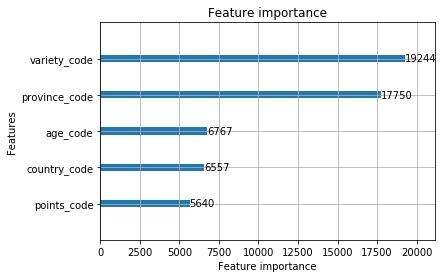

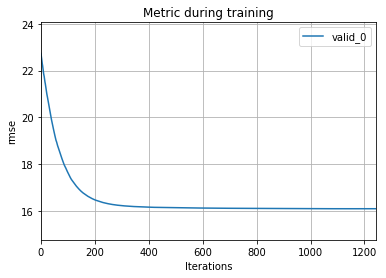

In [14]:
%matplotlib inline
lgb.plot_importance(model)
lgb.plot_metric(model)

In [15]:
with open('wine-price-prediction.model.lgbm.fitted.pickle', 'wb') as file:
    pickle.dump(model, file)

wine-price-prediction.model.lgbm.fitted.pickle
wine-price-prediction.model.lgbm.pickle


## Train MLP Neural Network

In [12]:
from keras.models import load_model

Using TensorFlow backend.


Let's define some useful functions.

In [13]:
from matplotlib import pyplot

def plot_training_loss(history):
    pyplot.subplots(figsize=(15, 5))
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper left')
    pyplot.show()

### Prepare Dataset

For use in MLP regressor let's one-hot encode all the categorical features in our dataset.

In [14]:
def one_hot_encode(df):
    for column in features:
        df = pd.get_dummies(df, columns=[column], prefix=column)
        
    return df

Let's one-hot encode test data and reshape into Numpy arrays.

In [15]:
train_x_enc = one_hot_encode(train_x)
train_x_np = train_x_enc.values.reshape(-1, train_x_enc.shape[1])
train_y_np = train_y.values.reshape(-1, 1)

valid_x_np = one_hot_encode(valid_x).values.reshape(-1, train_x_enc.shape[1])
valid_y_np = valid_y.values.reshape(-1, 1)

### Simple MLP Regressor

In [38]:
model2 = load_model('wine-price-prediction.model.keras.h5')

In [39]:
batch_size = 5000
history = model2.fit(train_x_np, train_y_np, validation_data=(valid_x_np, valid_y_np), shuffle=True, batch_size=batch_size, epochs=120)

Train on 68194 samples, validate on 17049 samples
Epoch 1/120
68194/68194 [==============================] - 8s 114us/step - loss: 1569.9393 - val_loss: 1426.0545
Epoch 2/120
68194/68194 [==============================] - 8s 114us/step - loss: 1363.9826 - val_loss: 1170.1249
Epoch 3/120
68194/68194 [==============================] - 8s 116us/step - loss: 1069.8746 - val_loss: 857.7330
Epoch 4/120
68194/68194 [==============================] - 8s 122us/step - loss: 765.1388 - val_loss: 602.3299
Epoch 5/120
68194/68194 [==============================] - 8s 113us/step - loss: 563.2876 - val_loss: 482.6531
Epoch 6/120
68194/68194 [==============================] - 8s 123us/step - loss: 479.7162 - val_loss: 437.5075
Epoch 7/120
68194/68194 [==============================] - 8s 119us/step - loss: 437.2237 - val_loss: 400.5822
Epoch 8/120
68194/68194 [==============================] - 8s 116us/step - loss: 402.9359 - val_loss: 372.0206
Epoch 9/120
68194/68194 [==============================] 

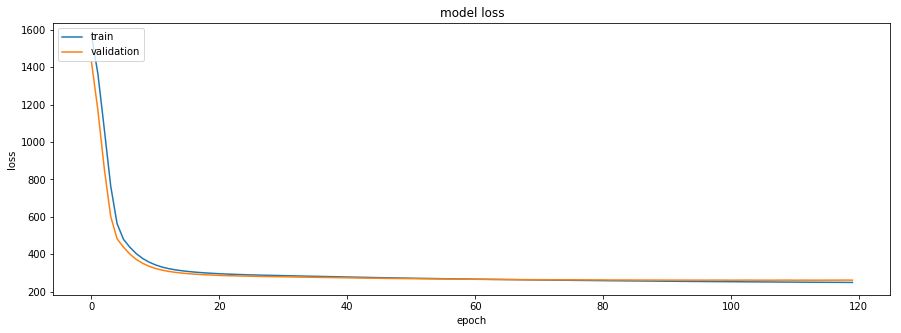

In [40]:
plot_training_loss(history)

In [23]:
model2.save("wine-price-prediction.model.keras.fitted.h5")

Let's add more complex arhitectures for the neural network regressor. We try both 'deeper' and 'wider' models.

### Deeper MLP Regressor

In [24]:
model3 = load_model('wine-price-prediction.model.keras.deep.h5')

In [28]:
batch_size = 5000
history = model3.fit(train_x_np, train_y_np, validation_data=(valid_x_np, valid_y_np), shuffle=True, batch_size=batch_size, epochs=30)

Train on 68194 samples, validate on 17049 samples
Epoch 1/30
68194/68194 [==============================] - 18s 268us/step - loss: 261.8164 - val_loss: 260.6288
Epoch 2/30
68194/68194 [==============================] - 19s 273us/step - loss: 260.7888 - val_loss: 260.4243
Epoch 3/30
68194/68194 [==============================] - 18s 265us/step - loss: 260.4087 - val_loss: 261.6883
Epoch 4/30
68194/68194 [==============================] - 19s 276us/step - loss: 260.2881 - val_loss: 260.6318
Epoch 5/30
68194/68194 [==============================] - 18s 268us/step - loss: 261.7450 - val_loss: 261.1884
Epoch 6/30
68194/68194 [==============================] - 18s 265us/step - loss: 260.2474 - val_loss: 264.0271
Epoch 7/30
68194/68194 [==============================] - 18s 264us/step - loss: 261.2988 - val_loss: 260.8481
Epoch 8/30
68194/68194 [==============================] - 18s 270us/step - loss: 259.9927 - val_loss: 260.9409
Epoch 9/30
68194/68194 [==============================] - 18s 

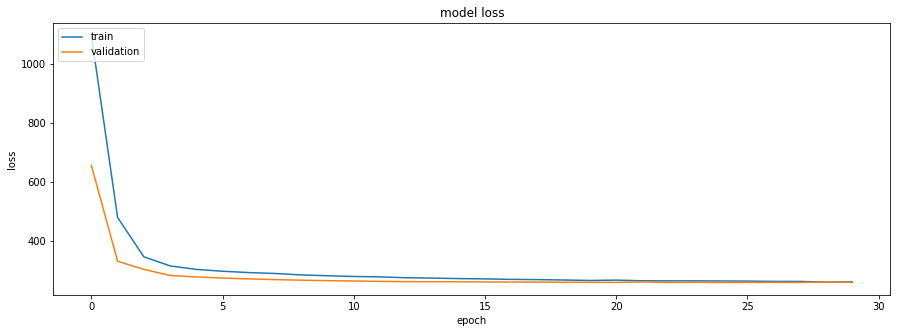

In [26]:
plot_training_loss(history)

In [29]:
model3.save("wine-price-prediction.model.keras.deep.fitted.h5")

### Wider MLP Regressor

In [30]:
model4 = load_model('wine-price-prediction.model.keras.wide.h5')

In [34]:
batch_size = 5000
history = model4.fit(train_x_np, train_y_np, validation_data=(valid_x_np, valid_y_np), shuffle=True, batch_size=batch_size, epochs=30)

Train on 68194 samples, validate on 17049 samples
Epoch 1/30
68194/68194 [==============================] - 35s 510us/step - loss: 255.0261 - val_loss: 260.4495
Epoch 2/30
68194/68194 [==============================] - 35s 507us/step - loss: 255.2228 - val_loss: 260.6127
Epoch 3/30
68194/68194 [==============================] - 35s 519us/step - loss: 254.6160 - val_loss: 260.8068
Epoch 4/30
68194/68194 [==============================] - 37s 545us/step - loss: 253.4203 - val_loss: 260.1584
Epoch 5/30
68194/68194 [==============================] - 37s 538us/step - loss: 253.9402 - val_loss: 260.8399
Epoch 6/30
68194/68194 [==============================] - 36s 531us/step - loss: 253.4720 - val_loss: 260.6596
Epoch 7/30
68194/68194 [==============================] - 37s 545us/step - loss: 253.4437 - val_loss: 260.6358
Epoch 8/30
68194/68194 [==============================] - 37s 541us/step - loss: 252.4700 - val_loss: 261.0666
Epoch 9/30
68194/68194 [==============================] - 38s 

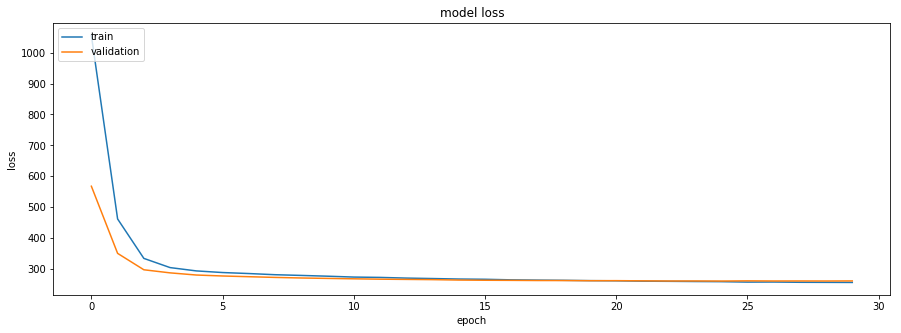

In [32]:
plot_training_loss(history)

In [35]:
model4.save("wine-price-prediction.model.keras.wide.fitted.h5")

### Final Model

Now, when we chose the final model architecture, let's train the model on the whole dataset we have.

In [41]:
full_x = df_data_1[features]
full_y = df_data_1["price"]

full_x_enc = one_hot_encode(full_x)

full_x_np = full_x_enc.values.reshape(-1, full_x_enc.shape[1])
full_y_np = full_y.values.reshape(-1, 1)

In [42]:
model_f = load_model('wine-price-prediction.model.keras.wide.h5')

In [43]:
batch_size = 5000
history = model_f.fit(full_x_np, full_y_np, shuffle=True, batch_size=batch_size, epochs=30)

Epoch 1/30
106554/106554 [==============================] - 117s 1ms/step - loss: 858.0340
Epoch 2/30
106554/106554 [==============================] - 115s 1ms/step - loss: 343.7297
Epoch 3/30
106554/106554 [==============================] - 113s 1ms/step - loss: 298.1928
Epoch 4/30
106554/106554 [==============================] - 117s 1ms/step - loss: 286.9928
Epoch 5/30
106554/106554 [==============================] - 113s 1ms/step - loss: 281.8773
Epoch 6/30
106554/106554 [==============================] - 113s 1ms/step - loss: 277.2947
Epoch 7/30
106554/106554 [==============================] - 114s 1ms/step - loss: 273.9952
Epoch 8/30
106554/106554 [==============================] - 112s 1ms/step - loss: 271.3300
Epoch 9/30
106554/106554 [==============================] - 116s 1ms/step - loss: 268.6635
Epoch 10/30
106554/106554 [==============================] - 112s 1ms/step - loss: 267.0740
Epoch 11/30
106554/106554 [==============================] - 111s 1ms/step - loss: 264.82

In [44]:
model_f.save("wine-price-prediction.model.keras.final.fitted.h5")